# Face Recognition

In this project, principal component analysis (PCA) is applied to reduce the dimension of a dataset of images in order to optimize a subsequent classification task. 

In [7]:
import sklearn
assert sklearn.__version__ >= '1.1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load and inspect data
Feth_lfw_people image dataset from sklearn

The dataset contains the following:  
- `faces.images` images as matrices of **50 x 37 pixels** (plottable) 
- `faces.data` flattened version of size **1850 x 1** *(50 x 37=1850)* 
- `faces.target` number index representing a class among 7

In [1]:
import sklearn
assert sklearn.__version__ >= '1.1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4, funneled=False)



❓ Run the cells below to check some basic facts about your data and see some images

In [4]:
print(f"- Images shape: {faces.images.shape}")
print(f"- Data (flattened images) shape: {faces.data.shape}")
print(f"- Target shape: {faces.target.shape}")
print(f"- Number of classes: {np.unique(faces.target).shape}")
print(f"- Each class is a famous person: {', '.join(faces.target_names)}")

- Images shape: (1288, 50, 37)
- Data (flattened images) shape: (1288, 1850)
- Target shape: (1288,)
- Number of classes: (7,)
- Each class is a famous person: Ariel Sharon, Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder, Hugo Chavez, Tony Blair


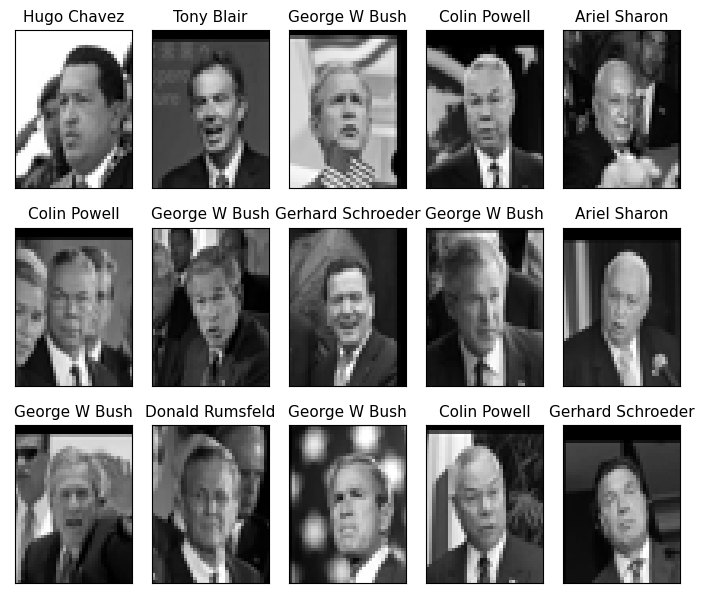

In [8]:
fig = plt.figure(figsize=(7,10))

for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(faces.images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()

## 2) Compression with PCA

The dataset contains 1288 images and 1850 features (50 × 37 pixels), a bad ratio for machine learning.
We will fit a `PCA` on the flattened images to reduce their dimensions to 150 components (gain by factor of $\frac{1850}{150} = 12$).  

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150, random_state = 42)
data_projected = pca.fit_transform(faces.data)
data_projected.shape

(1288, 150)

In [10]:
pca.components_.shape

(150, 1850)

In [14]:
pca.components_[0].shape, pca.components_[0] #One face is described as a linear combination of the components

((1850,),
 array([0.02307414, 0.02348633, 0.02348693, ..., 0.00612754, 0.00760942,
        0.0075133 ], dtype=float32))

Image reconstruction with `inverse_transform`

In [15]:
data_reconstructed = pca.inverse_transform(data_projected)
data_reconstructed.shape

(1288, 1850)

Plot a picture of the reconstructed dataset and compare it with the original one. 

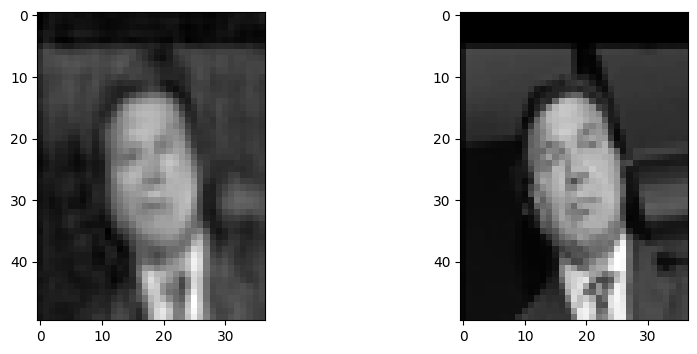

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(data_reconstructed[14].reshape((50,37)), cmap=plt.cm.gray)
axs[1].imshow(faces.images[14], cmap=plt.cm.gray);

Plot selection of reconstructed images

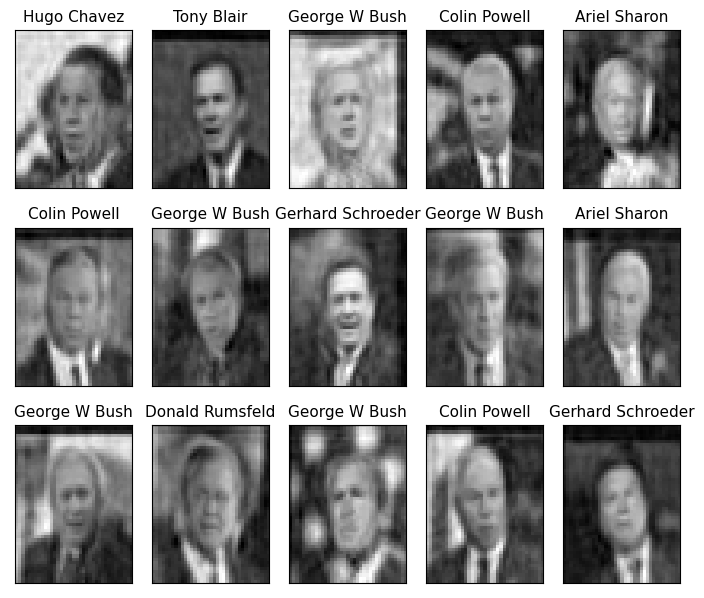

In [18]:
fig = plt.figure(figsize=(7,10))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(pca.inverse_transform(data_projected)[i].reshape((50,37)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
    
plt.tight_layout()

Plotting a gray image that corresponds to the *\"mean\"* face of the whole dataset  

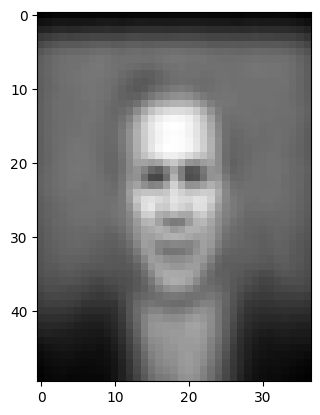

In [21]:
plt.imshow(pca.mean_.reshape((50,37)), cmap='gray');

Images of **first 5** principal components  

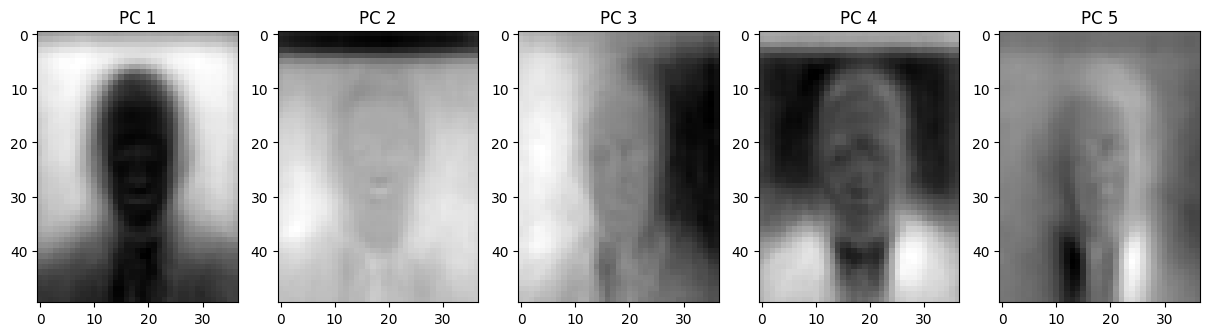

In [22]:
fig = plt.figure(figsize=(15,20))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(f'PC {i+1}', size=12)
    plt.imshow(pca.components_[i].reshape(50,37), cmap='gray')

Images of **last 5** principal components  

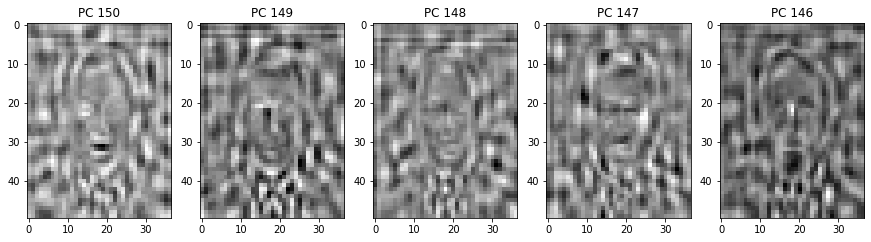

In [ ]:
# Last PCs
fig = plt.figure(figsize=(15,20))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(f'PC {pca.components_.shape[0] - i}', size=12)
    plt.imshow(pca.components_[-i -1].reshape(50,37), cmap='gray')

Plot several images corresponding to principal components

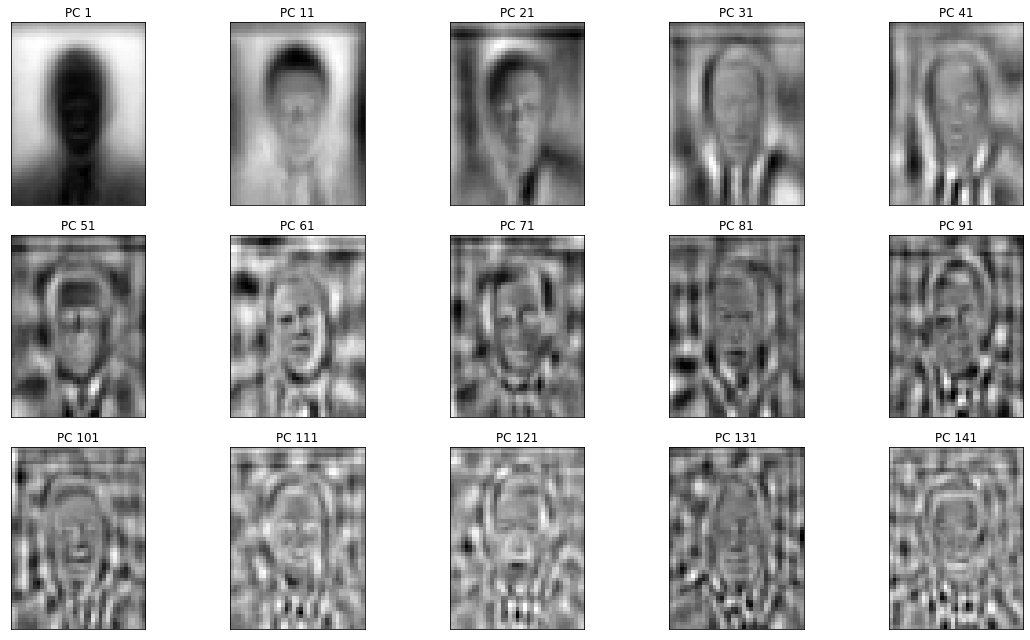

In [ ]:
n_rows, n_cols = 3, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))

for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    ax.set_title(f'PC {i * 10 + 1}', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(pca.components_[i * 10].reshape(50, 37), cmap='gray')

plt.tight_layout()

## Calculating the optimal number of components

**Supervised ML** task: Given a a picture of a face of a famous person, tell to whom the face belongs (7 classes). For this task, we will use support vector classification (SVC).

In [28]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from time import time

In [29]:
X = faces.data
y = faces.target

### Visualize cumulative sum of explained variance and choose manually
We will select the optimal number of componets visualizing the cumulative sum of explained variance ratio as a function of the number of components. This info is stored in the `explained_variance_ratio_` attribute of a the sklearn `PCA` object.   

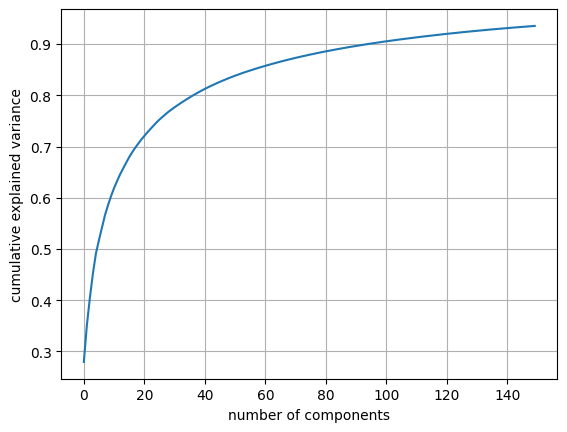

In [23]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()

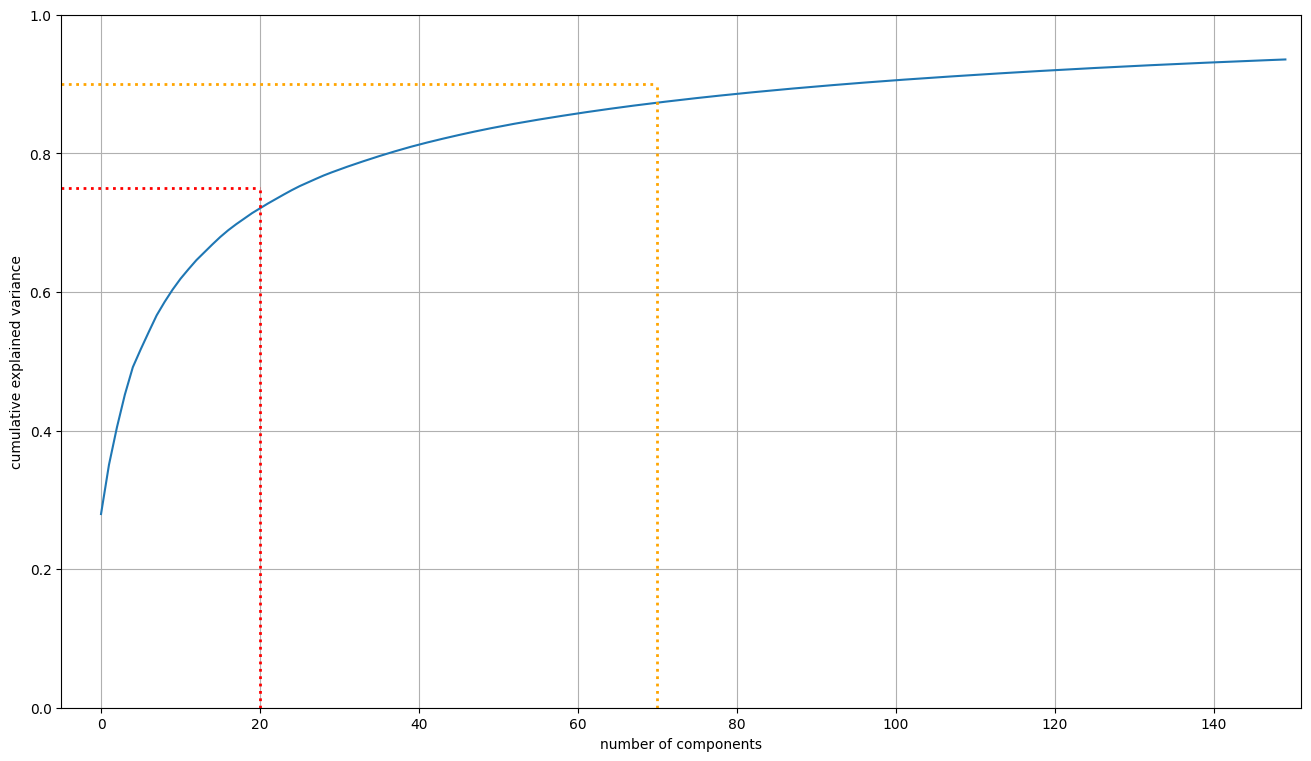

In [24]:
plt.figure(figsize=(16, 9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.xlim((-5, 151))
plt.ylim((0, 1))
plt.hlines(y=[.75, .9], xmin=[-5, -5], xmax=[20, 70],
           linestyles='dotted', colors=['red', 'orange'], linewidth=2)
plt.vlines(x=[20, 70], ymin=[0, 0], ymax=[.75, .9],
           linestyles='dotted', colors=['red', 'orange'], linewidth=2);

Calculate the minimal number of components needed to keep to get at least 80% of the variance  

In [25]:
cumulated_variance = np.cumsum(pca.explained_variance_ratio_)
minimal_pc_count = len(cumulated_variance[cumulated_variance <= 0.8]) + 1 # fill with the right answer
minimal_pc_count

38

### Search automatically with grid search

#### Train-test split

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [35]:
pipe = make_pipeline(PCA(random_state=42), SVC()) # random_state for reproducibility purposes
pipe.get_params()                                

{'memory': None,
 'steps': [('pca', PCA(random_state=42)), ('svc', SVC())],
 'verbose': False,
 'pca': PCA(random_state=42),
 'svc': SVC(),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': 42,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

5-fold cross-validation and search for number of PCA components among 50, 100, 200 and 300 

In [36]:
param_grid = {"pca__n_components": [50, 100, 200, 300]}

clf = GridSearchCV(pipe,
                   param_grid,
                   cv=5,
                   n_jobs=-1,
                   scoring='accuracy')

Fit the model

In [58]:
clf = clf.fit(X_train, y_train)
n_best_components = clf.best_estimator_.get_params()['pca__n_components']

In [44]:
from sklearn.metrics import classification_report

y_pred = clf.best_estimator_.predict(X_test)

We use these predictions against y_test to print the classification report

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.50      0.58        18
           1       0.73      0.54      0.62        69
           2       1.00      0.09      0.16        34
           3       0.51      0.98      0.67       166
           4       1.00      0.03      0.06        31
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        50

    accuracy                           0.55       387
   macro avg       0.56      0.31      0.30       387
weighted avg       0.55      0.55      0.44       387



/home/paularilo/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paularilo/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paularilo/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

## Fit SVC model on projected (PCA) data

**Supervised ML task**: Given a a picture of a face of a famous person, tell to whom the face belongs (7 classes). For this task, we will use support vector classification (SVC).

### Baseline model

In [64]:
baseline = pd.Series(y).value_counts(normalize=True).max()

score_base = cross_validate(make_pipeline(PCA(n_components=n_best_components),
                                             SVC()),
                               X, y,
                               scoring='accuracy',
                               cv=3,
                               n_jobs=-1)['test_score'].mean()


print(f"""Accuracy scores:
Baseline (frequency of most frequent class): {baseline: .2%}
Base Model (PCA + SVC): {score_base:.2%}""")

Accuracy scores:
Baseline (frequency of most frequent class):  41.15%
Base Model (PCA + SVC): 52.10%


### Scaling

Pipeline with 3 steps
- Scaling with `StandardScaler`
- `PCA` (use 200 components from earlier grid search)
- Fit `SVC`

In [51]:
from sklearn.preprocessing import StandardScaler
pipe_scaling = make_pipeline(StandardScaler(), PCA(n_components=n_best_components), SVC())

5-fold cross-validation on full **X** and **y**  

In [52]:
score_scaling = cross_validate(pipe_scaling,
                               X, y,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1)['test_score'].mean()

round(score_scaling, 3)

0.648

### Balancing

Representation of classes is unbalanced

In [54]:
pd.Series(y).value_counts(normalize=True)

3    0.411491
1    0.183230
6    0.111801
2    0.093944
4    0.084627
0    0.059783
5    0.055124
dtype: float64

We will train a second pipeline that takes into account the class imbalance with the argument class_weight of SVC

In [59]:
pipe_balanced = make_pipeline(StandardScaler(),
                              PCA(n_components=n_best_components),
                              SVC(class_weight='balanced'))

In [60]:
score_balanced = cross_validate(pipe_balanced, X, y, scoring='accuracy', cv=3, n_jobs=-1)['test_score'].mean()

round(score_balanced, 3)

0.651

### Fine-tuning

We will fine-tune the model to find a combination of 3 hyperparameters that yields the highest score  

ℹ️ These ranges of hyperparameters are examples and are not meant to offer the combination for the best model. Feel free to change the values!

In [61]:
pipe_balanced._final_estimator.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [62]:
grid = {'svc__kernel': ['rbf', 'poly', 'sigmoid'],
        'svc__gamma': [1e-4, 1e-3, 1e-2],
        'svc__C': [10, 1e2, 1e3]}

search = GridSearchCV(pipe_balanced, 
                      grid,
                      cv=3,
                      scoring='accuracy')

search.fit(X, y)
score_tuned = search.best_score_
round(score_tuned, 5)

0.76473

**Accuracy is increased by 20 points compared to baseline model, although it remains rather modest**

## Reconstruction of an original image

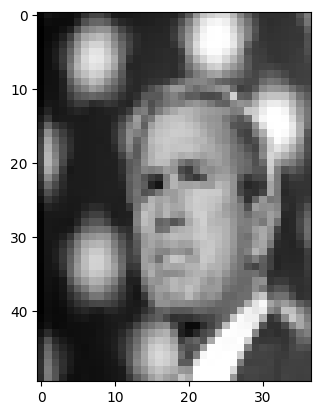

In [67]:
# We do our reconstruction over the 13th image
image_original = faces.images[12];
image_compressed = data_projected[12];

plt.imshow(image_original, cmap='gray');

manually do the sum of multiplications $X\_reconstructed_{i} = \sum_{i=1}^{n\_components}{X_{projected_i} * W_i}$  
$W_i$ being the `i-th principal component`  

In [68]:
# start at mean over all images
image_reconstructed = pca.mean_.copy(); 

# Reconstruct the image by doing the sum of every 150 entry of its compressed representation, weighted by the corresponding PCs

reconstruction = list()
for i in range(pca.n_components_):
    image_reconstructed += pca.components_[i] * image_compressed[i]
    reconstruction.append(image_reconstructed.copy())

Plot the reconstructed image alongside the original

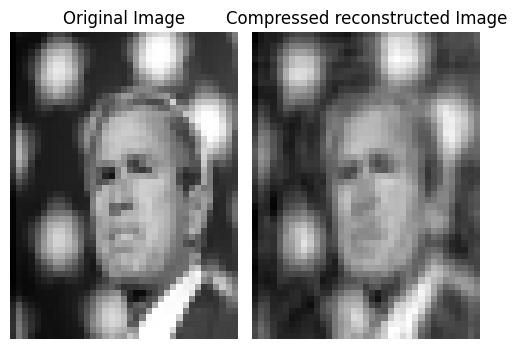

In [69]:
# Plot the original and the compressed image.
fig, ax = plt.subplots(1, 2, figsize = (5,5))
ax[0].imshow(image_original, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image_reconstructed.reshape(faces.images[0].shape), cmap='gray')
ax[1].set_title('Compressed reconstructed Image')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

Plot the image at different steps of reconstruction

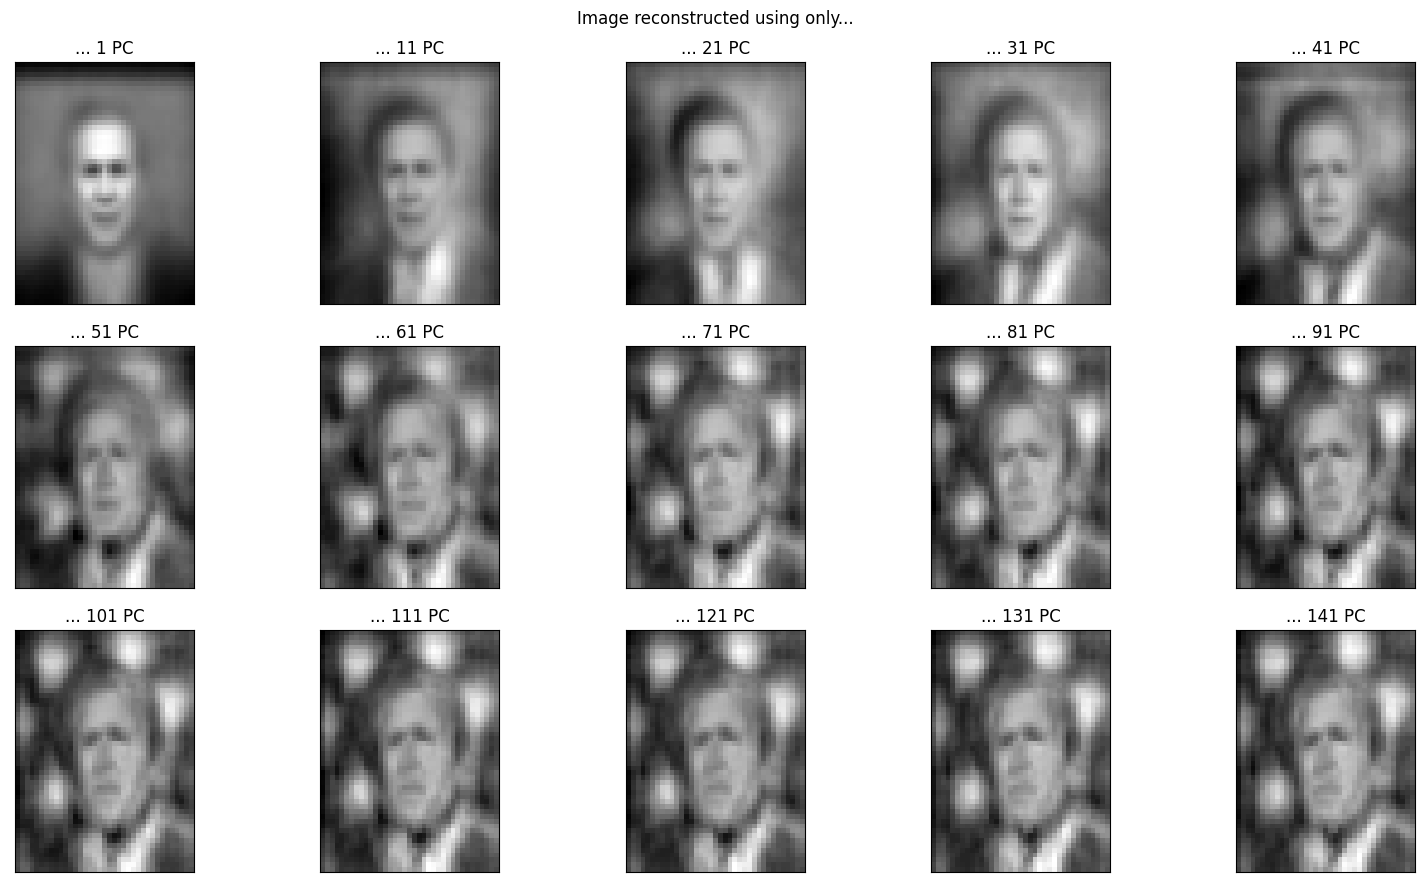

In [70]:
# Plot several images at different steps of reconstruction
n_rows, n_cols = 3, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))
plt.suptitle('Image reconstructed using only...')

for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    ax.set_title(f'... {i * 10 + 1} PC', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(reconstruction[i * 10].reshape(50, 37), cmap='gray')

plt.tight_layout()